# 08-auto-binary-tests.ipynb

# Import packages

In [75]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import imageio as iio
import skimage.exposure
import skimage.filters
import skimage.morphology
import skimage.util
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load test image

In [2]:
imgs_list = [path for path in (Path(module_path) / 'example-imgs').glob('*.tif')]
img = iio.imread(imgs_list[0])
img = skimage.util.img_as_float(img)
print(img.shape)

(1004, 924)


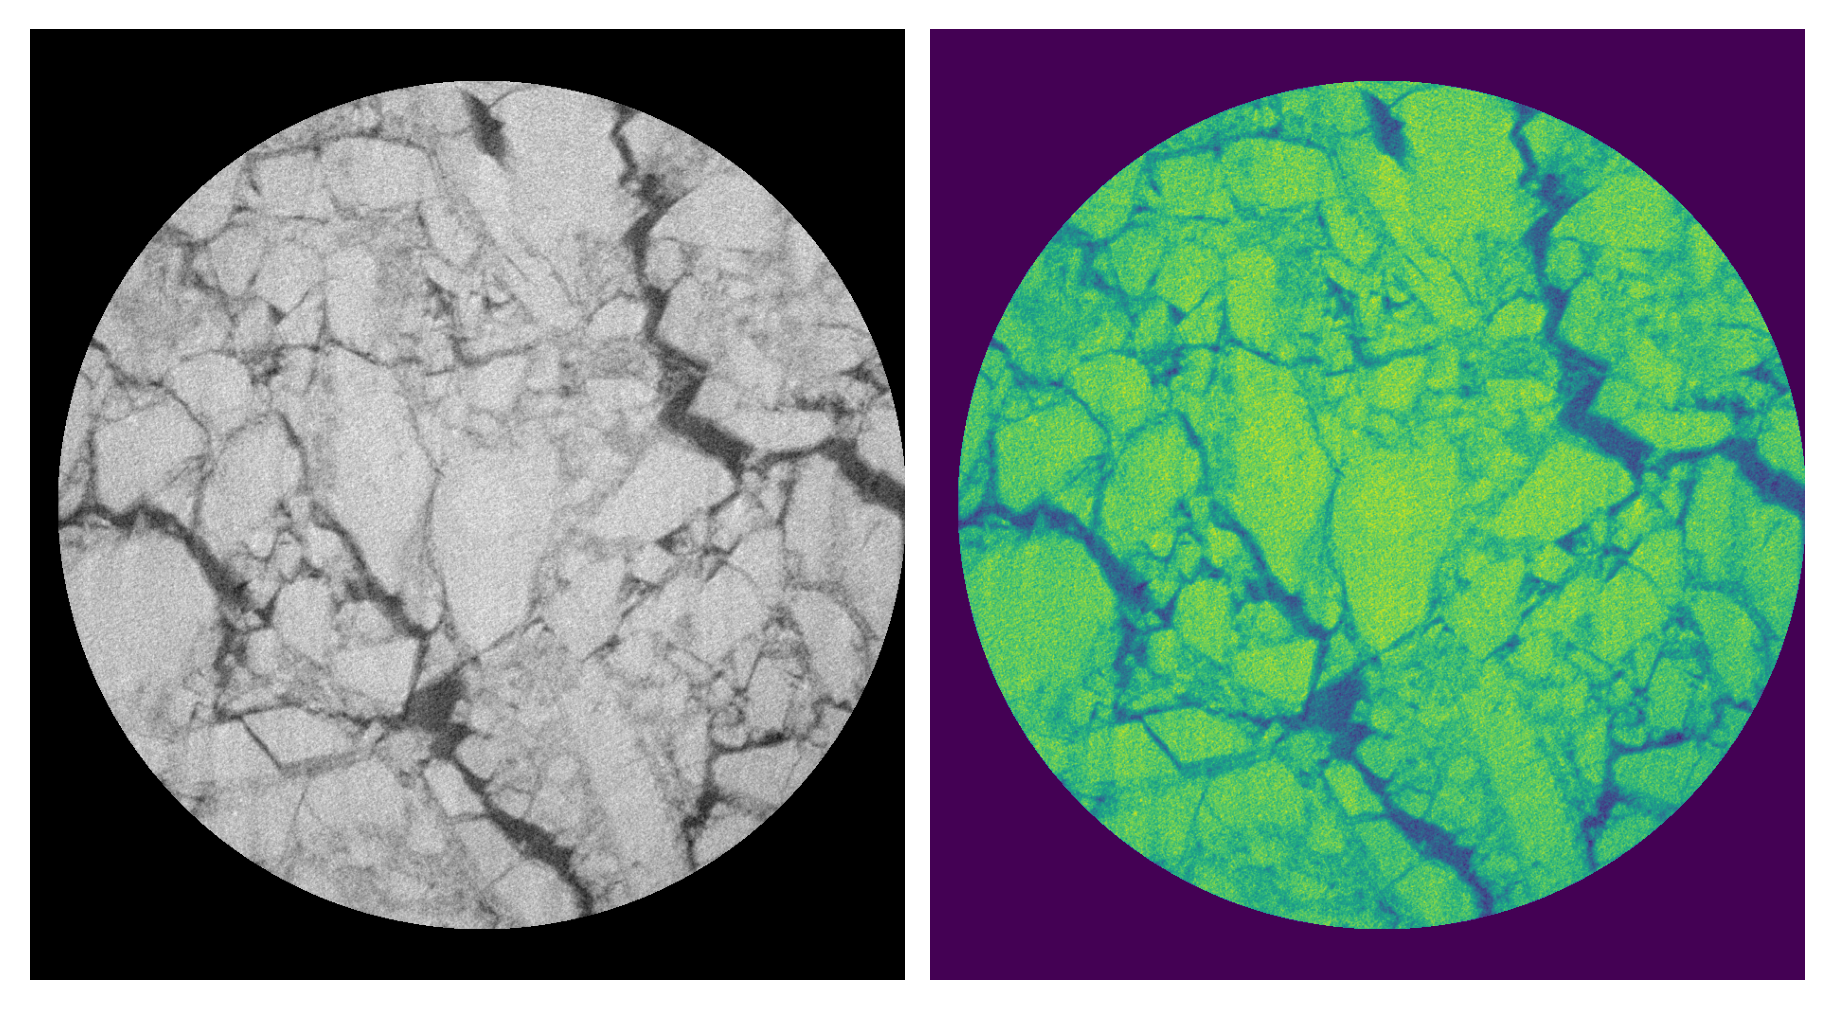

In [74]:
def show_img_w_falsecolor(img, dpi=150, **kwargs):
    fig, axes = plt.subplots(1, 2, dpi=dpi, constrained_layout=True)
    for ax, cmap in zip(axes.ravel(), ['gray', 'viridis']):
        ax.imshow(img, cmap=cmap)
        ax.set_axis_off()
    return fig, ax
fig, axes = show_img_w_falsecolor(img, dpi=300)
plt.show()

# Binarization tests

## Multi-otsu without pre-processing

In [92]:
def multiotsu(img, nthresh):
    thresh_vals = skimage.filters.threshold_multiotsu(img, nthresh)
    thresh_img = np.zeros_like(img, dtype=np.float32)
    for i, val in enumerate(thresh_vals):
        thresh_img[img > val] = 1 / (nthresh - 1) * (i + 1)
    return thresh_img, thresh_vals 

def multiple_multiotsu(img, multiotsu_range):
    multiotsu_img_dict = {}
    multiotsu_thresh_val_dict = {}
    for n in multiotsu_range:
        multiotsu_img_dict[n], multiotsu_thresh_val_dict[n] = multiotsu(img, n)
    return multiotsu_img_dict, multiotsu_thresh_val_dict

def plot_multiple_multiotsu(img, multiotsu_range, dpi=150, constrained_layout=True):
    fig, axes = plt.subplots(1, len(multiotsu_range), dpi=dpi, constrained_layout=constrained_layout)
    ax = axes.ravel()
    for ax, n in zip(axes.ravel(), multiotsu_range):
        img_otsu, thresh_vals = multiotsu(img, n)
        thresh_vals_rounded = [round(val, 3) for val in thresh_vals]
        ax.imshow(img_otsu, interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Calculated threshold values:\n{thresh_vals_rounded}', fontsize=5)
    return fig, axes

def plot_multiple_multiotsu_w_hist(
    img, multiotsu_range, ylims=None, fig_w=5, dpi=150, constrained_layout=True
):
    hist, hist_centers = skimage.exposure.histogram(img)
    nrows = 2
    ncols = len(multiotsu_range)
    img_w = img.shape[1]
    img_h = img.shape[0]
    title_buffer = 0.15
    fig_h = title_buffer + fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, constrained_layout=constrained_layout)
    for i, n in enumerate(multiotsu_range):
        img_otsu, thresh_vals = multiotsu(img, n)
        axes[0, i].imshow(img_otsu, interpolation='nearest', vmin=0, vmax=1)
        axes[0, i].axis('off')
        # Round thresh_vals to put in axis titles
        thresh_vals_rounded = [round(val, 3) for val in thresh_vals]
        axes[0, i].set_title(
            f'Calculated threshold values:\n{thresh_vals_rounded}', fontsize=5
        )
        axes[1, i].plot(hist_centers, hist)
        for val in thresh_vals:
            axes[1, i].axvline(val, color='r')
        if ylims is not None:
            axes[1, i].set_ylim(*ylims)
        axes[1, i].axis('off')
    return fig, axes

def plot_multiple_multiotsu_w_binary(img, multiotsu_range, n_upper_thresh_binary=1, fig_w=5, dpi=150, constrained_layout=True):
    nrows = 2
    ncols = len(multiotsu_range)
    img_w = img.shape[1]
    img_h = img.shape[0]
    title_buffer = 0.35
    fig_h = title_buffer + fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, constrained_layout=constrained_layout)
    for i, n in enumerate(multiotsu_range):
        img_otsu, thresh_vals = multiotsu(img, n)
        axes[0, i].imshow(img_otsu, interpolation='nearest', vmin=0, vmax=1)
        axes[0, i].axis('off')
        # Round thresh_vals to put in axis titles
        thresh_vals_rounded = [round(val, 3) for val in thresh_vals]
        axes[0, i].set_title(
            f'Calculated threshold values:\n{thresh_vals_rounded}', fontsize=5
        )
        n_upper_thresh_binary_adjusted = n_upper_thresh_binary
        if len(thresh_vals) < n_upper_thresh_binary:
            n_upper_thresh_binary_adjusted = len(thresh_vals)
        binary_thresh_val = thresh_vals[-n_upper_thresh_binary_adjusted]
        axes[1, i].imshow(img > binary_thresh_val, interpolation='nearest', vmin=0, vmax=1)
        axes[1, i].axis('off')
        # Round thresh_vals to put in axis titles
        binary_thresh_val_rounded = round(binary_thresh_val, 3)
        axes[1, i].set_title(
            f'Pixels above threshold: {binary_thresh_val_rounded}', 
            fontsize=5
        )
    return fig, axes

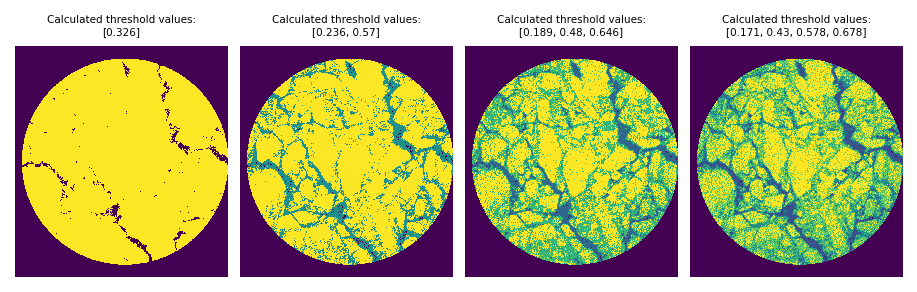

In [5]:
fig, axes = plot_multiple_multiotsu(img, range(2, 6), dpi=150)
plt.show()

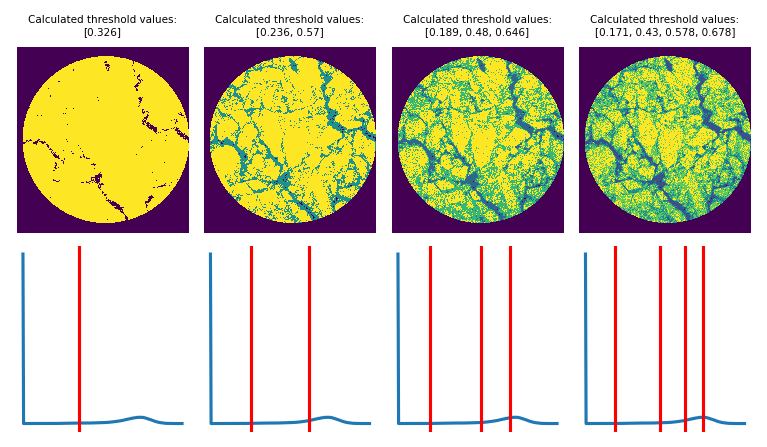

In [93]:
fig, axes = plot_multiple_multiotsu_w_hist(img, range(2, 6), dpi=150)
plt.show()

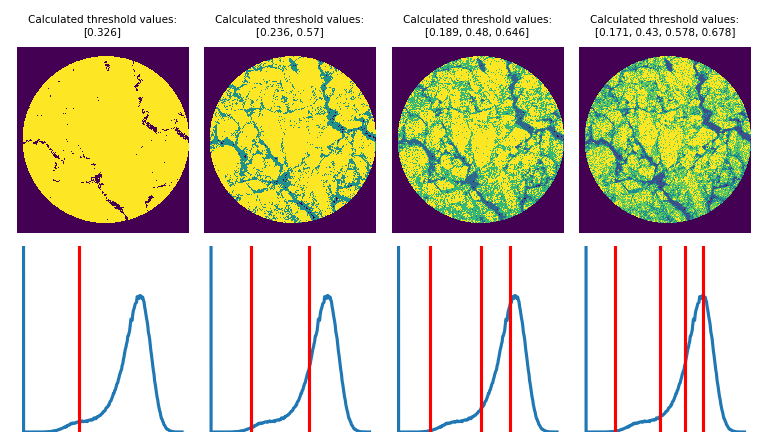

In [95]:
fig, axes = plot_multiple_multiotsu_w_hist(img, range(2, 6), dpi=150, ylims=[0, 15000])
plt.show()

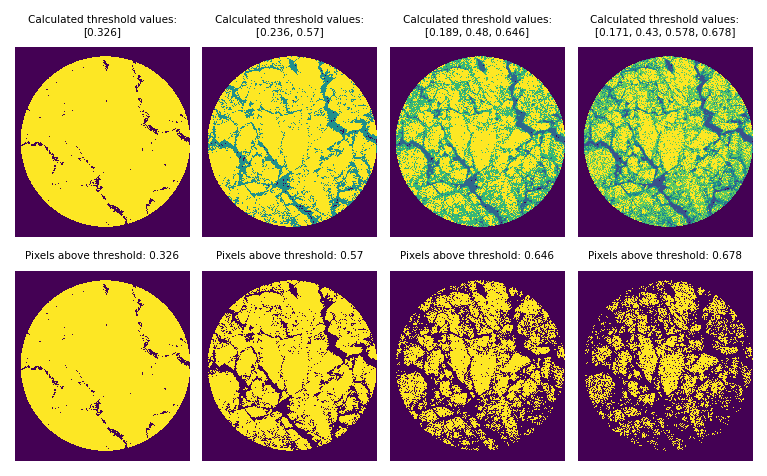

In [6]:
fig, axes = plot_multiple_multiotsu_w_binary(img, range(2, 6), n_upper_thresh_binary=1, dpi=150)
plt.show()

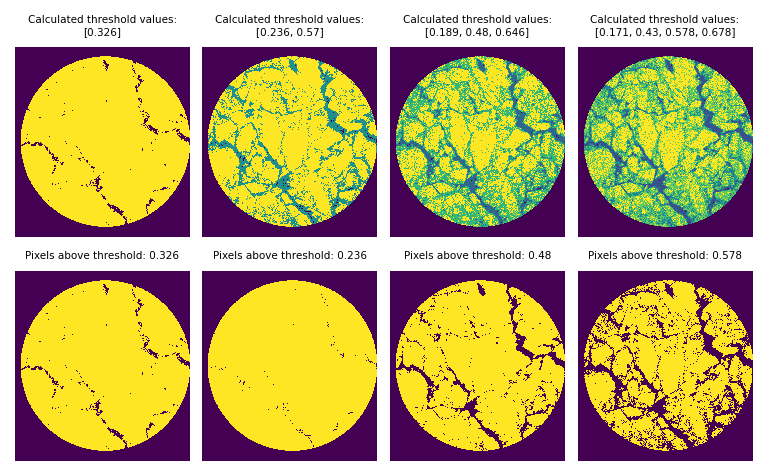

In [7]:
fig, axes = plot_multiple_multiotsu_w_binary(img, range(2, 6), n_upper_thresh_binary=2, dpi=150)
plt.show()

# F50 Sand

## Multi-otsu

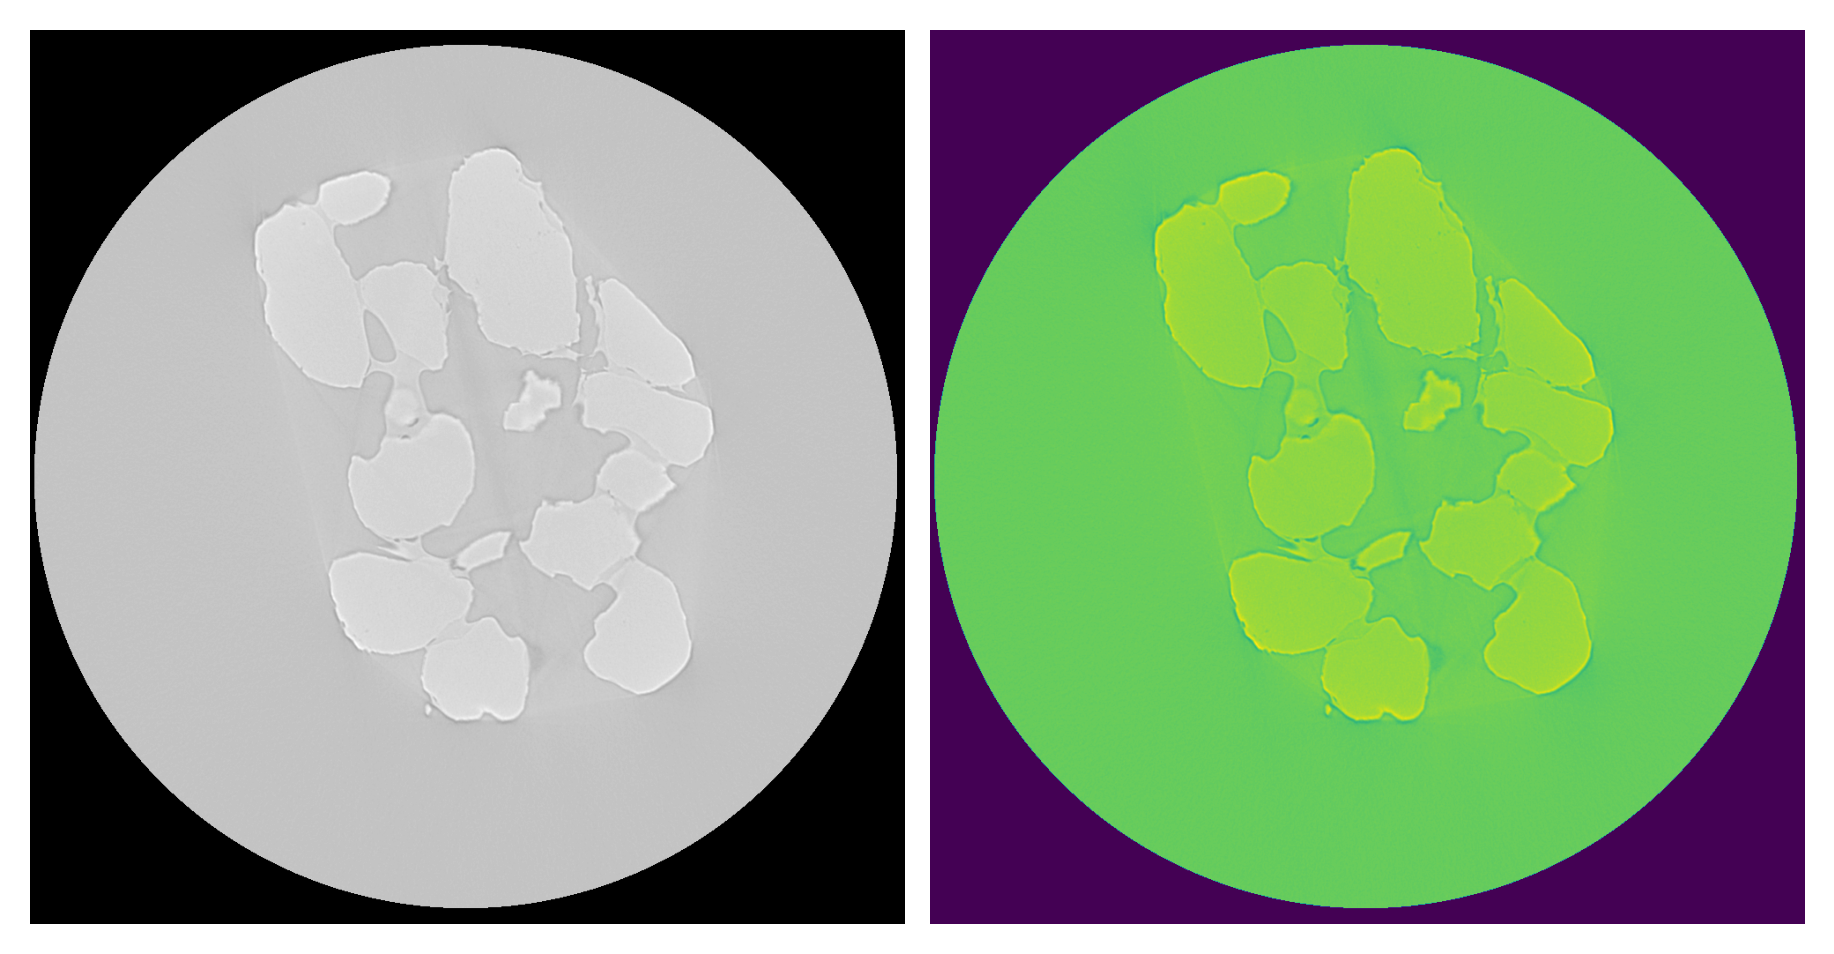

In [65]:
sand_img_path = Path(r'C:\Users\cgusb\Research\mhe-analysis\data\Formulate Sand Cluster 04_25_22\0500.tiff')
sand_img = iio.imread(sand_img_path)
sand_img = skimage.util.img_as_float(sand_img)
fig, axes = plt.subplots(1, 2, dpi=300, constrained_layout=True)
for ax, cmap in zip(axes.ravel(), ['gray', 'viridis']):
    ax.imshow(sand_img, cmap=cmap)
    ax.set_axis_off()
plt.show()

In [ ]:
ums_per_pixel = 580 / (225 - 18)
print(ums_per_pixel)

2.8019323671497585


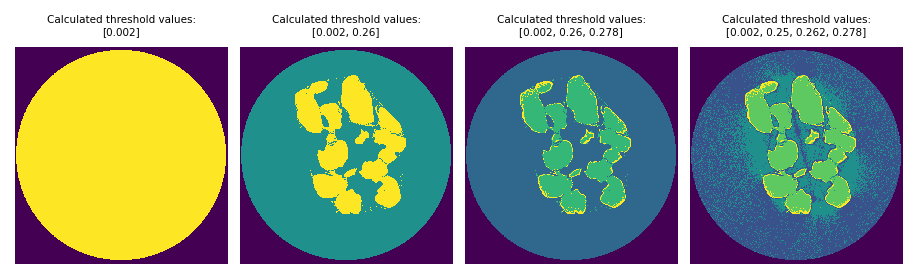

In [9]:
fig, axes = plot_multiple_multiotsu(sand_img, range(2, 6), dpi=150)
plt.show()

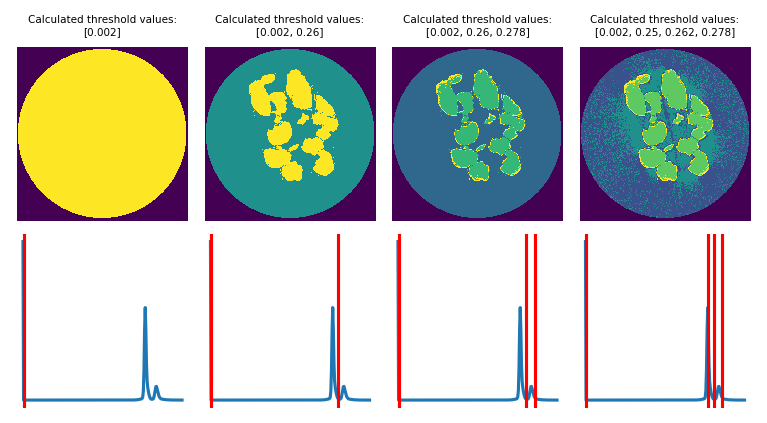

In [96]:
fig, axes = plot_multiple_multiotsu_w_hist(sand_img, range(2, 6), dpi=150)
plt.show()

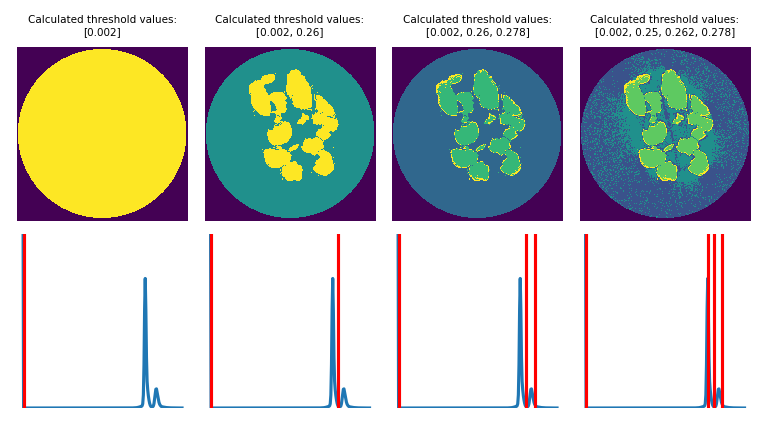

In [99]:
fig, axes = plot_multiple_multiotsu_w_hist(sand_img, range(2, 6), dpi=150, ylims=[0, 200000])
plt.show()

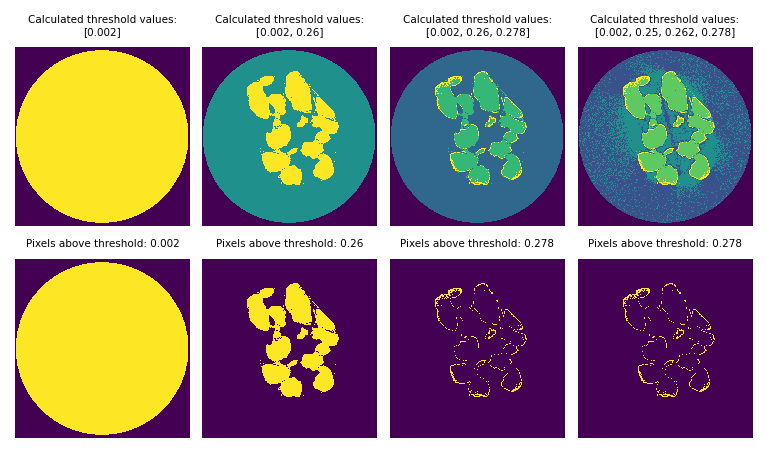

In [11]:
fig, axes = plot_multiple_multiotsu_w_binary(
    sand_img, range(2, 6), n_upper_thresh_binary=1, dpi=150
)
plt.show()

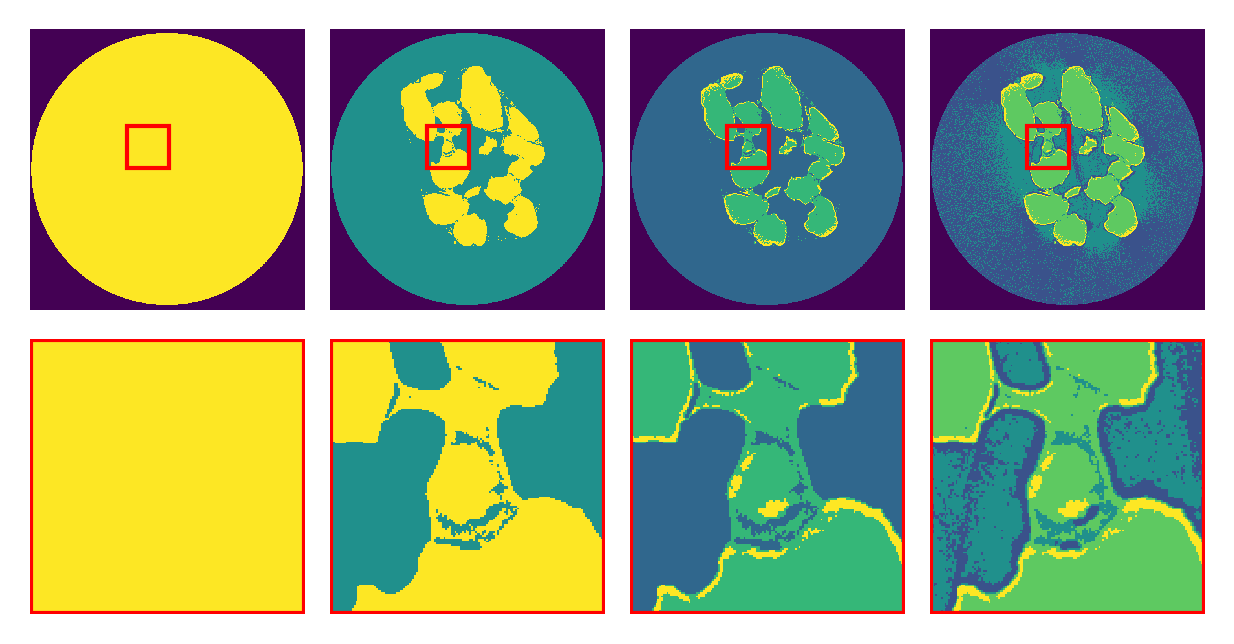

In [72]:
def compare_imgs_w_cropped(img_sequence, row_range, col_range, fig_w=3, dpi=300):
    # img_sequence_list is a list of image sequences, each image sequence a list of images in itself
    nrows = 2
    ncols = len(img_sequence)
    img_h, img_w = img_sequence[0].shape
    fig_h = fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, constrained_layout=True
    )
    for i, img in enumerate(img_sequence):
        axes[0, i].imshow(
            img, vmin=0, vmax=1, interpolation='nearest'
        )
        # Create a Rectangle patch
        rect = mpatches.Rectangle(
            (row_range[0], col_range[0]), 
            col_range[1] - col_range[0], 
            row_range[1] - row_range[0], 
            linewidth=1, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        axes[0, i].add_patch(rect)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(
            img[row_range[0]:row_range[1], col_range[0]:col_range[1]], 
            vmin=0, vmax=1, interpolation='nearest'
        )
        # Create a Rectangle patch
        rect = mpatches.Rectangle(
            (0, 0), 
            col_range[1] - col_range[0] - 1, 
            row_range[1] - row_range[0] - 1, 
            linewidth=1, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        axes[1, i].add_patch(rect)
        axes[1, i].set_axis_off()
    return fig, axes
sand_multiotsu_imgs, sand_multiotsu_thresh_vals = multiple_multiotsu(
    sand_img, range(2, 6)
)
fig, axes = compare_imgs_w_cropped(
    list(sand_multiotsu_imgs.values()),
    [350, 500], [350, 500], dpi=300, fig_w=4
)
plt.show()

## Detect edges

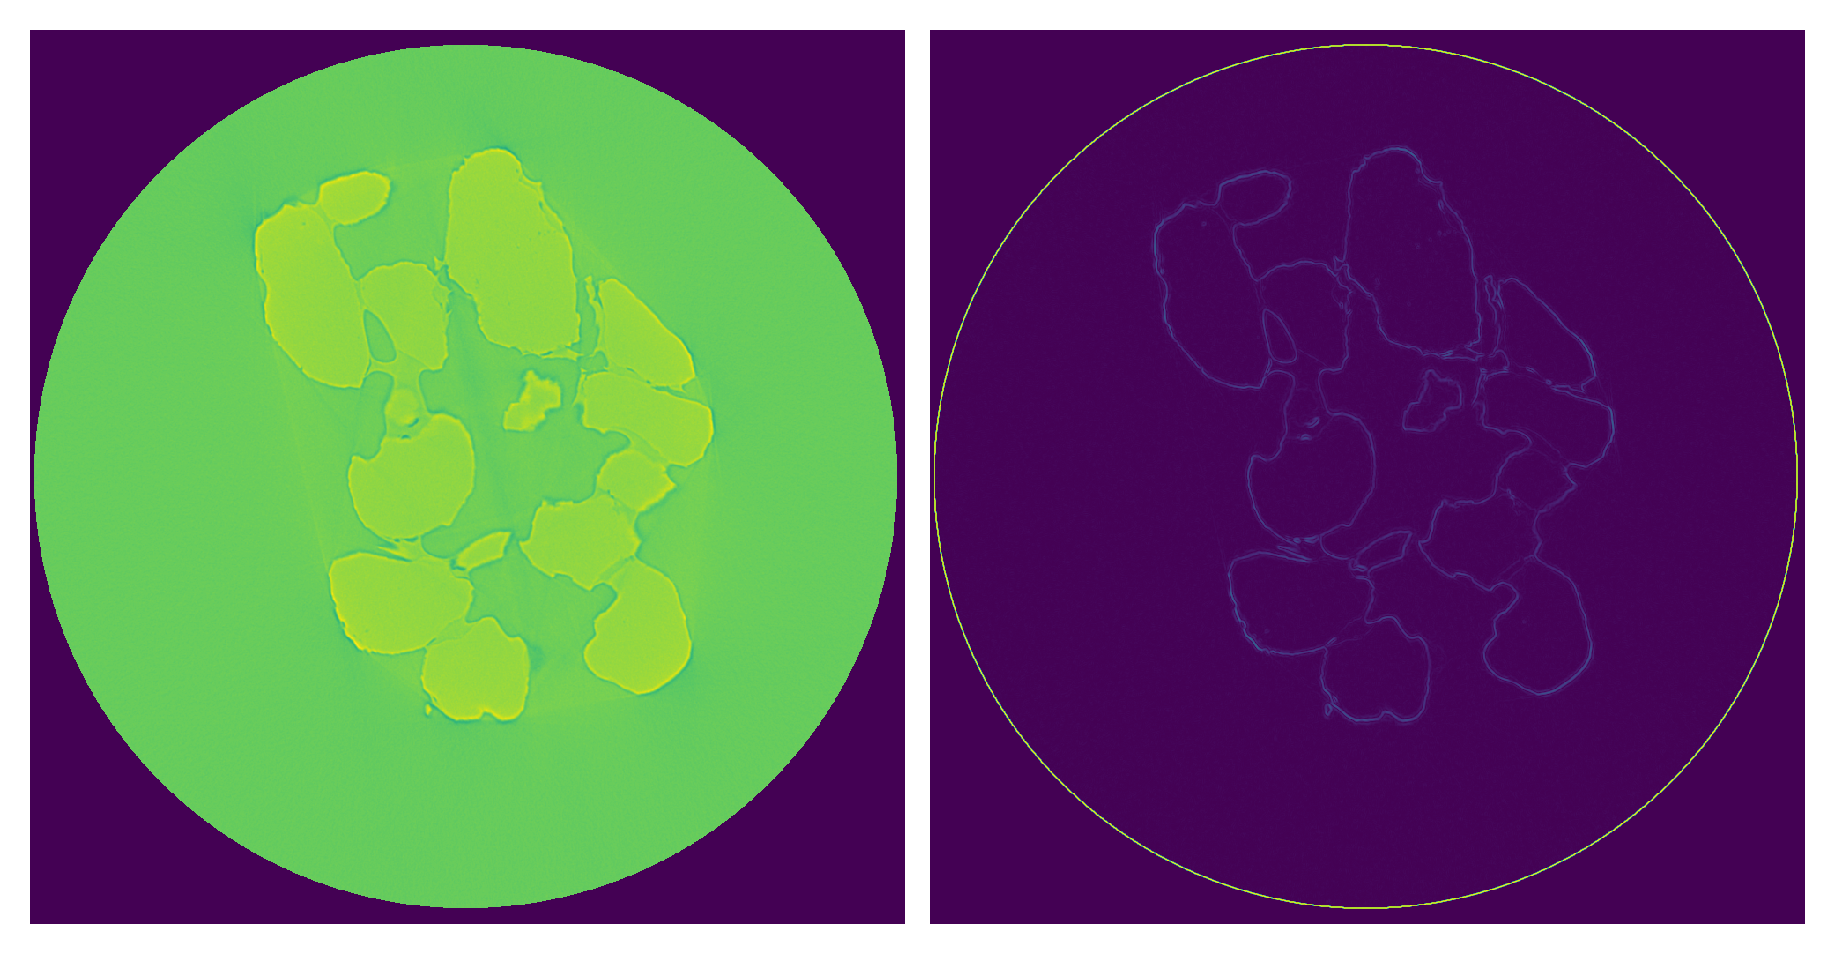

In [18]:
sand_edges = skimage.filters.sobel(sand_img)
fig, axes = plt.subplots(1, 2, dpi=300, constrained_layout=True)
ax = axes.ravel()
ax[0].imshow(sand_img, interpolation='nearest')
ax[1].imshow(sand_edges, interpolation='nearest')
for a in ax:
    a.set_axis_off()
plt.show()

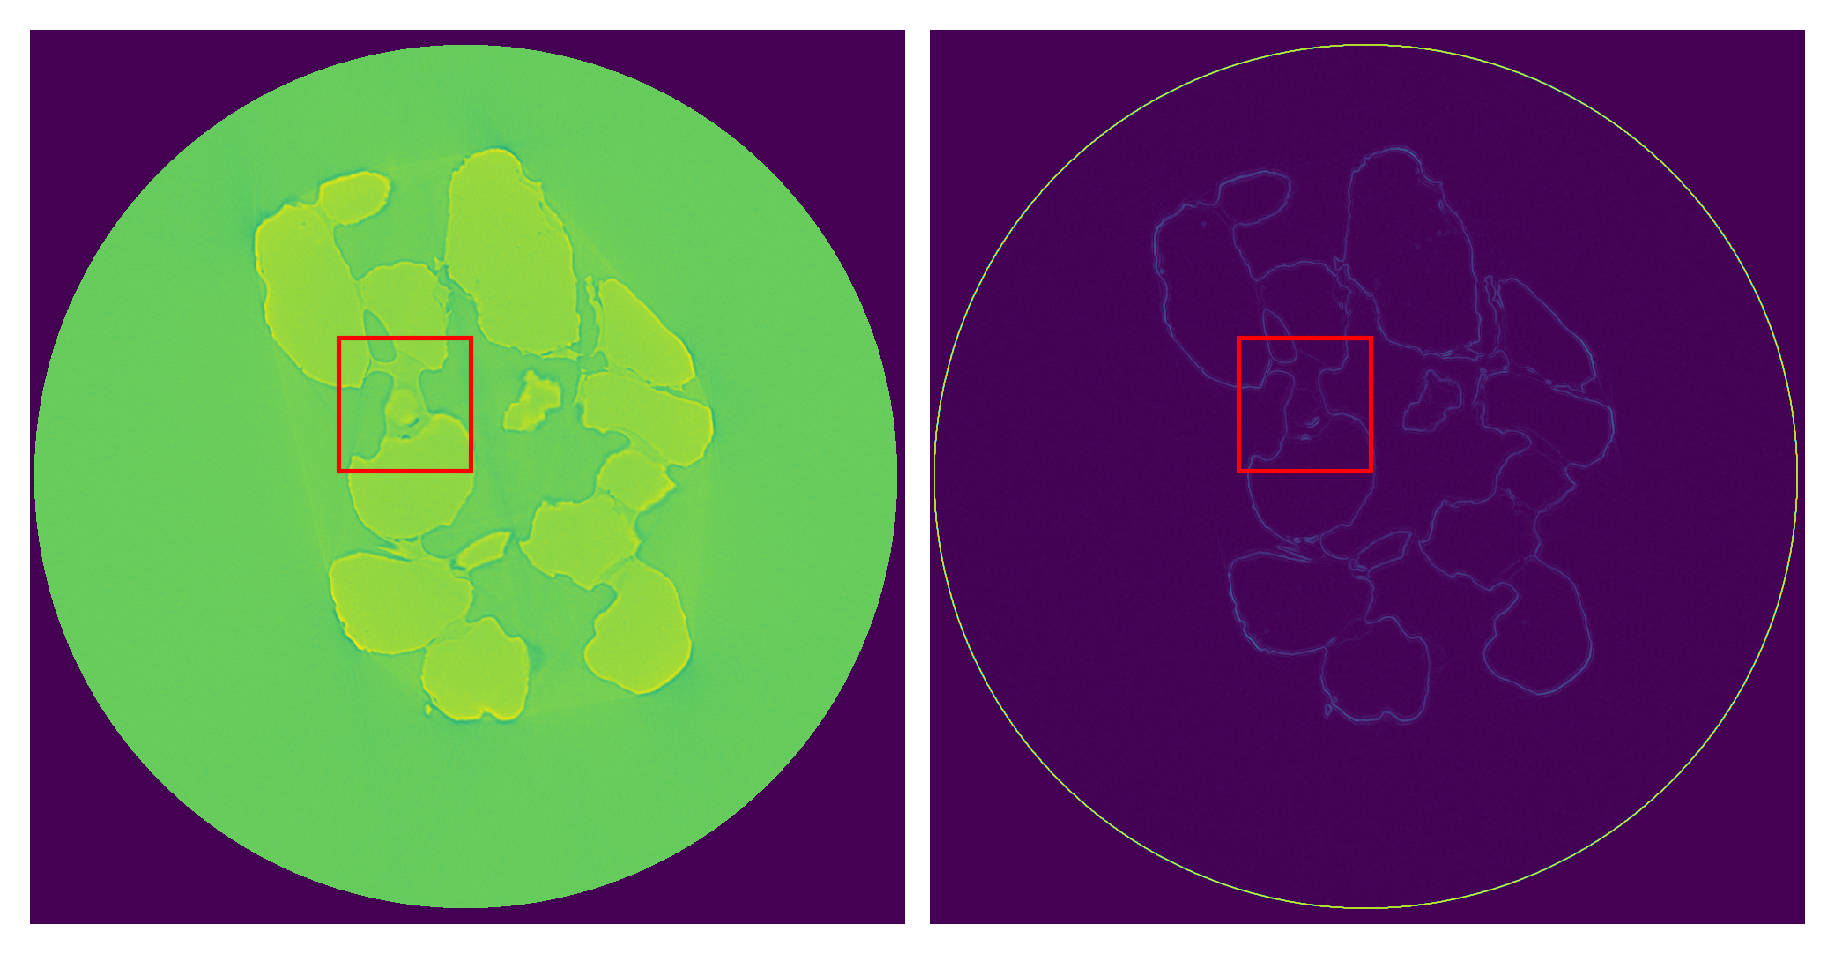

In [21]:
fig, axes = plt.subplots(1, 2, dpi=300, constrained_layout=True)
ax = axes.ravel()
ax[0].imshow(sand_img, interpolation='nearest')
ax[1].imshow(sand_edges, interpolation='nearest')
for a in ax:
    # Create a Rectangle patch
    rect = mpatches.Rectangle(
        (350, 350), 150, 150, linewidth=1, edgecolor='r', facecolor='none'
    )
    # Add the patch to the Axes
    a.add_patch(rect)
    a.set_axis_off()
plt.show()

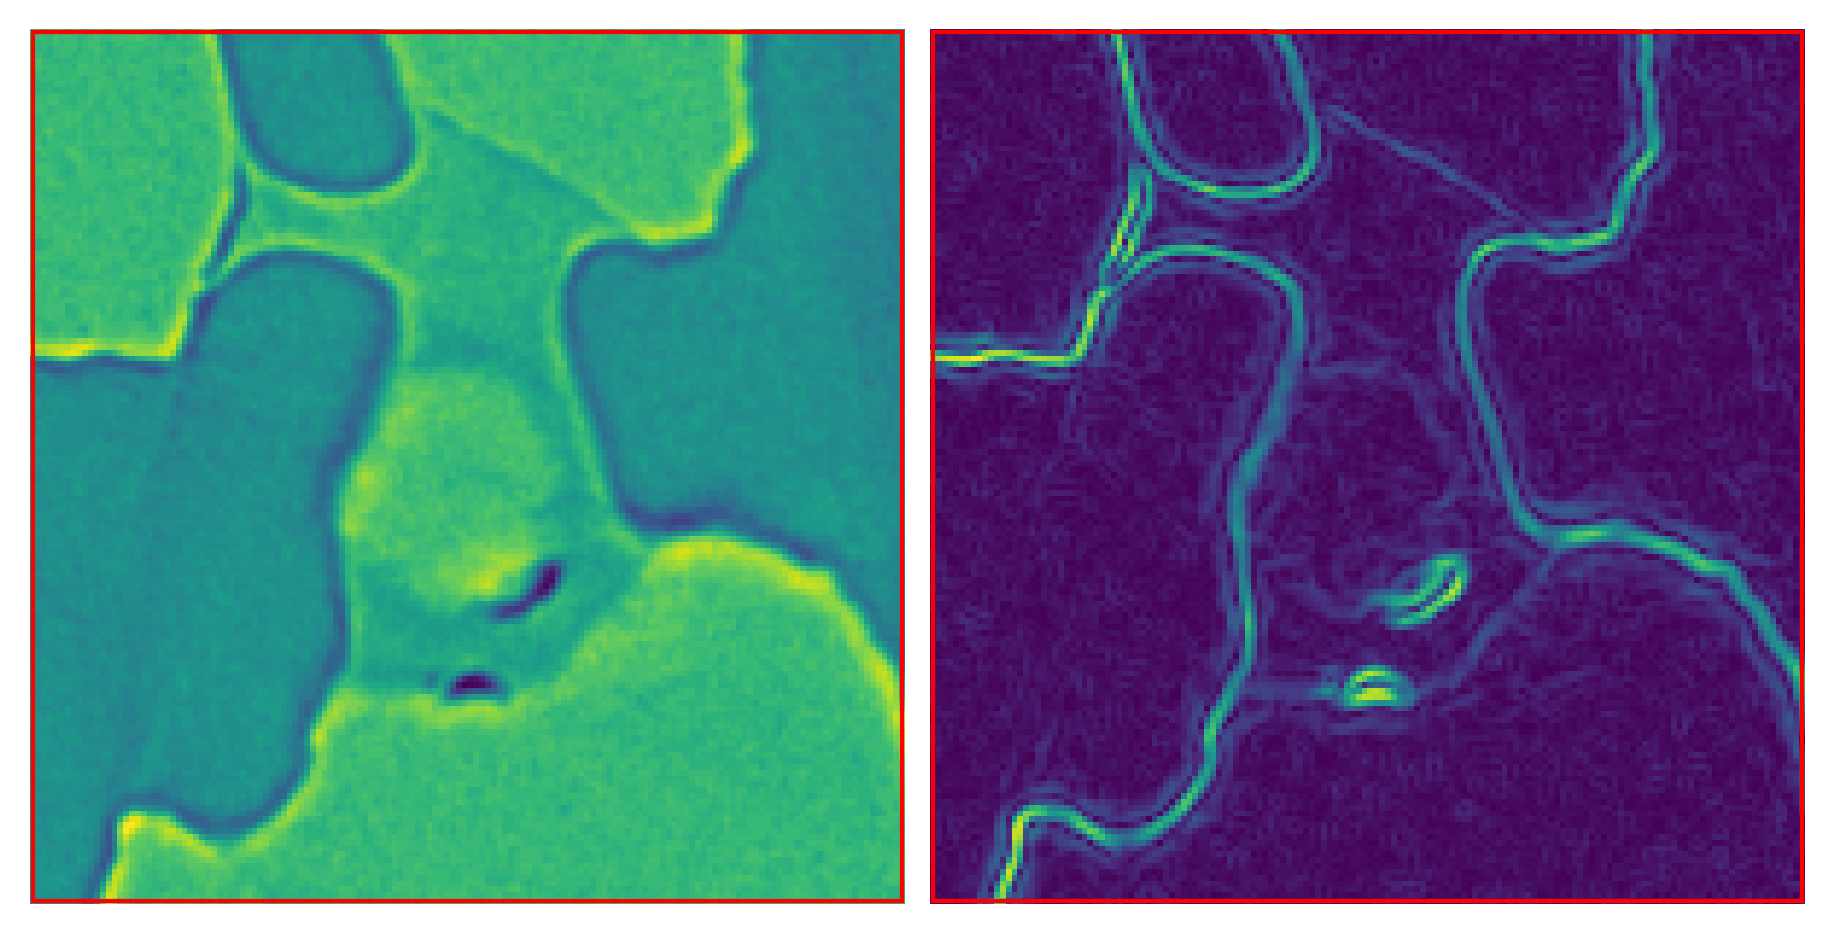

In [37]:
def show_imgs_cropped(imgs_list, row_range, col_range, dpi=150, red_outline=False):
    ncols = len(imgs_list)
    fig, axes = plt.subplots(1, ncols, dpi=dpi, constrained_layout=True)
    for ax, img in zip(axes.ravel(), imgs_list):
        ax.imshow(
            img[row_range[0]:row_range[1], col_range[0]:col_range[1]], 
            interpolation='nearest'
        )
        if red_outline:
            # Create a Rectangle patch
            rect = mpatches.Rectangle(
                (0, 0), 
                col_range[1] - col_range[0] - 1, 
                row_range[1] - row_range[0] - 1, 
                linewidth=1, edgecolor='r', facecolor='none'
            )
            # Add the patch to the Axes
            ax.add_patch(rect)
        ax.set_axis_off()
    return fig, axes
show_imgs_cropped([sand_img, sand_edges], [350, 500], [350, 500], dpi=300, red_outline=True)
plt.show()

In [61]:
def compare_imgs_cropped(img_sequence_list, row_range, col_range, fig_w=3, dpi=150):
    # img_sequence_list is a list of image sequences, each image sequence a list of images in itself
    nrows = len(img_sequence_list)
    ncols = len(img_sequence_list[0])
    img_h = row_range[1] - row_range[0]
    img_w = col_range[1] - col_range[0]
    fig_h = fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, constrained_layout=True
    )
    for i in range(nrows):
        for ax, img in zip(axes[i, :], img_sequence_list[i]):
            ax.imshow(
                img[row_range[0]:row_range[1], col_range[0]:col_range[1]], 
                interpolation='nearest'
            )
            ax.set_axis_off()
    return fig, axes

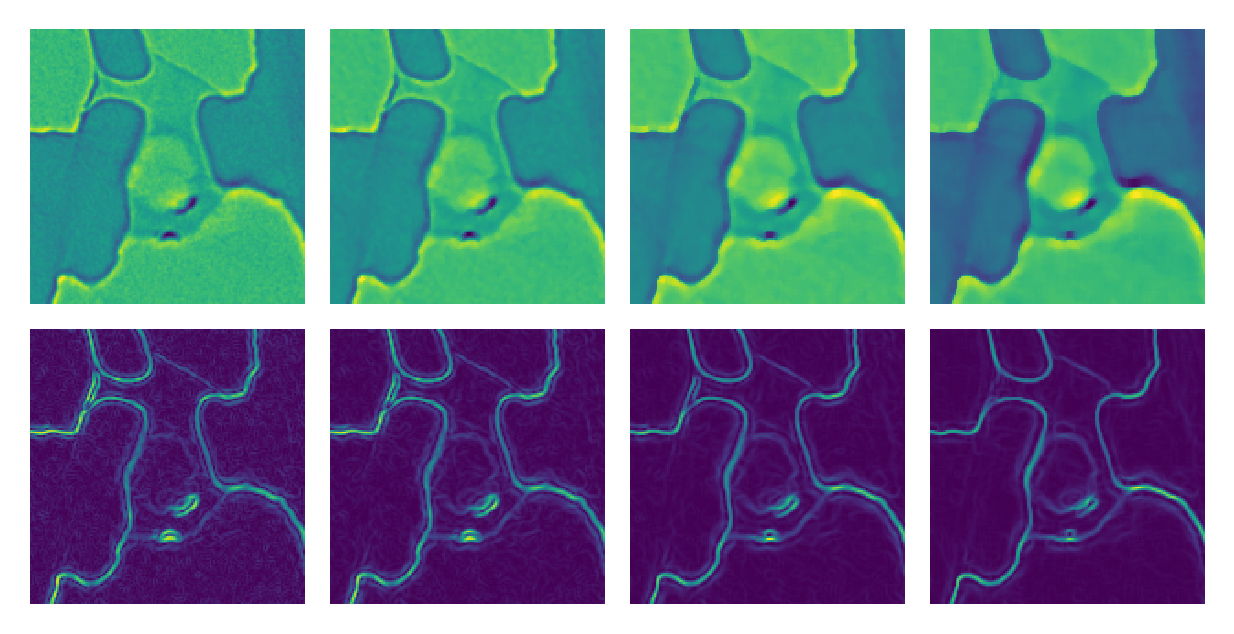

In [52]:
sand_med_imgs = [
    skimage.filters.median(sand_img, footprint=skimage.morphology.square(n))
    for n in [3, 5, 7]
]
sand_med_edges = [
    skimage.filters.sobel(sand_med_img) for sand_med_img in sand_med_imgs
]
sand_edge = skimage.filters.sobel(sand_img)
compare_imgs_cropped(
    [[sand_img] + sand_med_imgs, [sand_edge] + sand_med_edges], 
    [350, 500], [350, 500], dpi=300, fig_w=4
)
plt.show()

C:\Users\cgusb\AppData\Local\Temp/ipykernel_15288/571178799.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  skimage.filters.rank.gradient(sand_img, footprint=skimage.morphology.disk(n))


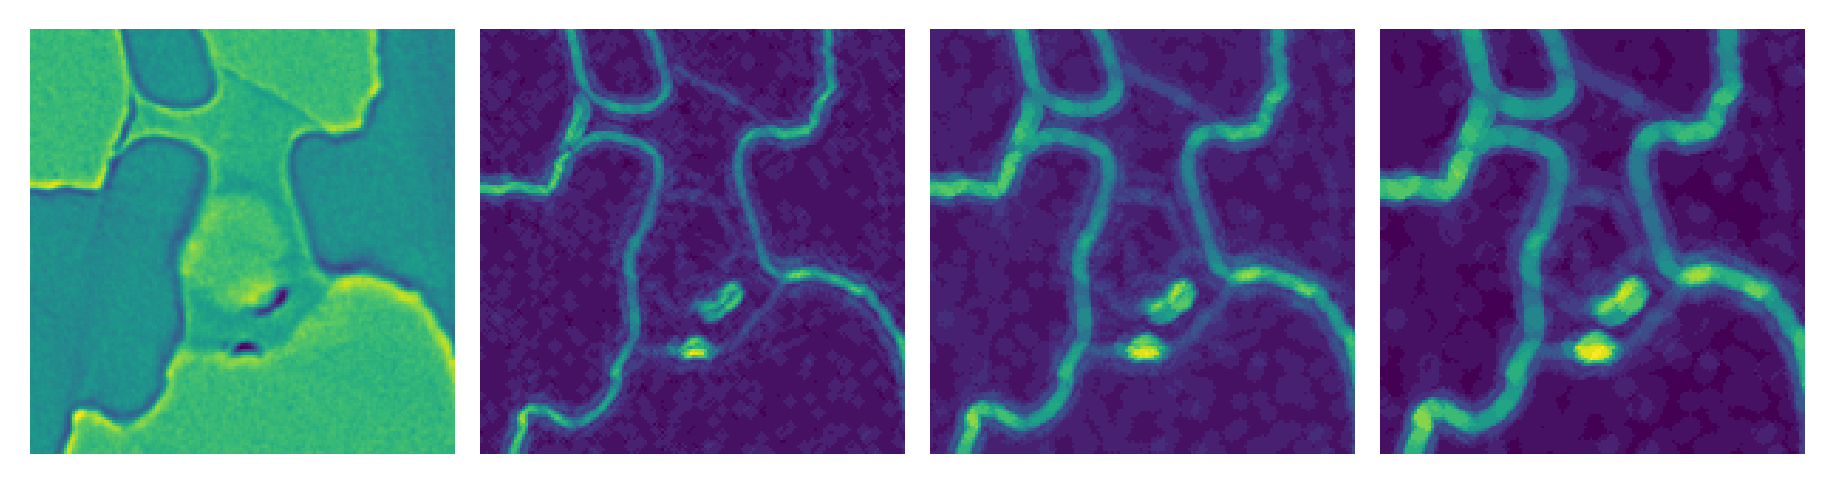

In [62]:
sand_grad_imgs = [
    skimage.filters.rank.gradient(sand_img, footprint=skimage.morphology.disk(n)) 
    for n in [2, 3, 4]
]
show_imgs_cropped([sand_img] + sand_grad_imgs, [350, 500], [350, 500], dpi=300)
plt.show()

C:\Users\cgusb\AppData\Local\Temp/ipykernel_15288/3844339756.py:3: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  row2_imgs = [skimage.filters.rank.gradient(img, footprint=skimage.morphology.disk(2)) for img in row0_imgs]


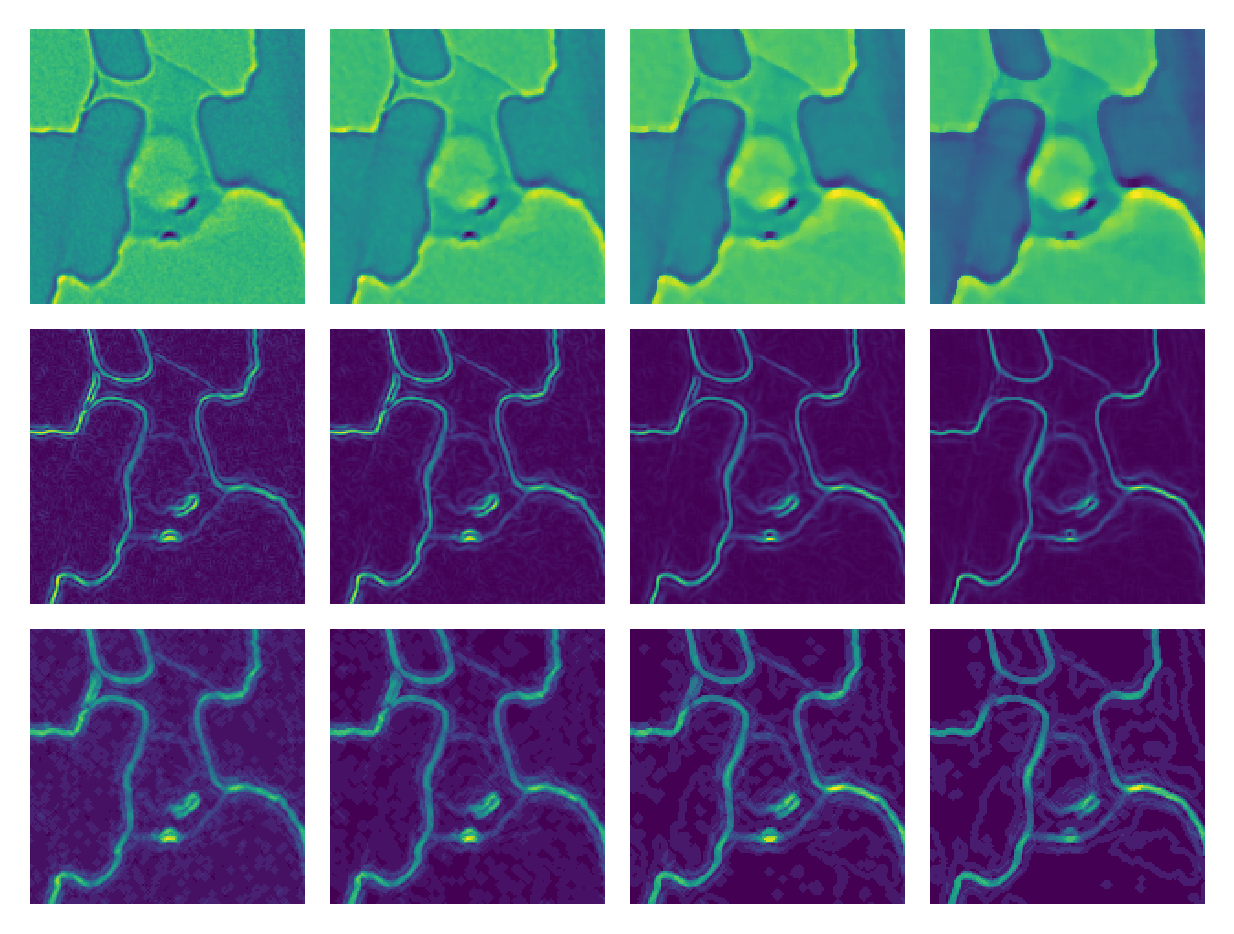

In [63]:
row0_imgs = [sand_img] + sand_med_imgs
row1_imgs = [sand_edge] + sand_med_edges
row2_imgs = [skimage.filters.rank.gradient(img, footprint=skimage.morphology.disk(2)) for img in row0_imgs]
compare_imgs_cropped(
    [row0_imgs, row1_imgs, row2_imgs], 
    [350, 500], [350, 500], dpi=300, fig_w=4
)
plt.show()